In [6]:
!pip install flax
from tqdm.notebook import tqdm
import math
import os
import matplotlib.pyplot as plt
import cv2
import jax
import jax.numpy as jnp                # JAX NumPy
from google.colab.patches import cv2_imshow
from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax    
#download dataset
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-10-09 14:34:26--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2022-10-09 14:34:26--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz.2’

tiny_nerf_data.npz. 100%[===================>]  12.14M  5.68MB/s    in 2.1s    

2022-10-09 14:34:29 (5.68 MB/s) - ‘tiny_nerf_data.npz.2’ saved [12727482/12727482]



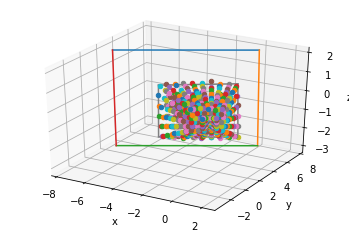

In [7]:
#visualise the cam and world rays and points
def rayCastPointVisualisation(x,y,focal,camera_toworld_matrix,imgW,imgH,Tf=6.0,Tn=2.0,numPoints=64,PRNGKey=None):
    #near_bound = 2.0,far_bound = 6.0
    x_wrt_cam, y_wrt_cam , z_wrt_cam =x - imgW*0.5, -y +imgH*0.5,  -focal
    rayDirections_wrt_Cam = jnp.array([[x_wrt_cam, y_wrt_cam , z_wrt_cam]])
    unitVecCam = rayDirections_wrt_Cam/(rayDirections_wrt_Cam**2).sum()**0.5
    unitVec_wrt_world = jnp.matmul(camera_toworld_matrix[:3,:3],unitVecCam.T)#using Rmatrix for getting direction of projected rays wrt world
    camPos_wrt_world = camera_toworld_matrix[:3,-1] #using Tmatrix for getting origin (camera pos) of projected rays wrt world
    #now we sample points along the rays going into the camera wrt to world space between Tnear and Tfar for the camera 
    width = (Tf-Tn)/numPoints
    points = []
    directions =[]
    ts =[]
    imageEdges = jnp.array([[0- imgW*0.5,-0 +imgH*0.5,-focal,1],[imgW-1- imgW*0.5,-0 +imgH*0.5,-focal,1],
    [imgW-1- imgW*0.5,-(imgH-1) +imgH*0.5,-focal,1],[0- imgW*0.5,-(imgH-1) +imgH*0.5,-focal,1]])
    imagePlanewrtWorld = jnp.matmul(camera_toworld_matrix,imageEdges.T).T[:,:3]
    edgeUnitVecwrtCam = imageEdges[:,:3]/(jnp.expand_dims(jnp.sum(imageEdges[:,:3]**2,axis=1),1)**0.5)
    edgeUnitVecwrtWorld = jnp.matmul(camera_toworld_matrix[:3,:3],edgeUnitVecwrtCam.T).T
    camposesArray = jnp.array([camPos_wrt_world,camPos_wrt_world,camPos_wrt_world,camPos_wrt_world])
    nearPlanewrtWorld = camposesArray + Tn*edgeUnitVecwrtWorld
    farPlanewrtWorld = camposesArray + Tf*edgeUnitVecwrtWorld
    for  i in range(1,numPoints+2):
        PRNGKey,rngkey = jax.random.split(PRNGKey)
        ti =  jax.random.uniform(rngkey,minval=Tn+(i-1)*width, maxval=Tn+i*width) #uniform sample ( tn + (i-1)*w , tn+ i*w )
        del rngkey
        ts.append(ti)
        #print(unitVec_wrt_world.T[0] ,unitVec_wrt_world)
        points.append(camPos_wrt_world + unitVec_wrt_world.T[0]*ti) # p= O + Dt
        directions.append(unitVec_wrt_world.T[0])
        
    deltas = jnp.expand_dims(jnp.diff(jnp.array(ts)),1)
    directions = jnp.array(directions)
    points = jnp.array(points)
    return points[:-1],directions[:-1],deltas,imagePlanewrtWorld,nearPlanewrtWorld,farPlanewrtWorld

from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
pose = jnp.array([[ 8.42908502e-01,-9.50274467e-02,5.29598951e-01,2.13488197e+00],
  [ 5.38057029e-01,1.48867935e-01,-8.29658270e-01,-3.34445977e+00],
  [ 7.45058237e-09,9.84280407e-01,1.76612213e-01,7.11946666e-01],
  [ 0.00000000e+00,0.00000000e+00,0.00000000e+00,1.00000000e+00]])
def plotRays(focal,camera_toworld_matrix,imgW,imgH,Tf,Tn,numPoints,PRNGKey):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  for x in range(imgW):
    for y in range(imgH):
      # Data for a three-dimensional line
      PRNGKey,rngkey = jax.random.split(PRNGKey)
      points,directions,deltas,imagePlane,nearPlanewrtWorld,farPlanewrtWorld= rayCastPointVisualisation(x=x,y=y,focal=focal,camera_toworld_matrix=camera_toworld_matrix,imgW=imgW,imgH=imgH,Tf=Tf,Tn=Tn,numPoints=numPoints,PRNGKey=rngkey)
      del rngkey
      origin = [camera_toworld_matrix[:3,-1][0],camera_toworld_matrix[:3,-1][1],camera_toworld_matrix[:3,-1][2]]
      #print(points.shape,directions.shape,deltas.shape)
      for p in range(points.shape[0]):
        #print(deltas[p],((points[p]-points[p+1])**2).sum()**0.5)#checking if deltas = distance btw points
        #print(points.shape,directions.shape,deltas.shape)
        ax.scatter(points[p][0],points[p][1],points[p][2],)#points
      ax.scatter(directions[0][0]+origin[0],directions[0][1]+origin[1],directions[0][2]+origin[2],)#points
      ax.plot3D([origin[0],directions[0][0]+origin[0]], [origin[1],directions[0][1]+origin[1]],[origin[2],directions[0][2]+origin[2]])#lines
  #plotting image plane
  ax.plot3D([imagePlane[0,0],imagePlane[1,0]],[imagePlane[0,1],imagePlane[1,1]],[imagePlane[0,2],imagePlane[1,2]])#lines
  ax.plot3D([imagePlane[1,0],imagePlane[2,0]],[imagePlane[1,1],imagePlane[2,1]],[imagePlane[1,2],imagePlane[2,2]])#lines
  ax.plot3D([imagePlane[2,0],imagePlane[3,0]],[imagePlane[2,1],imagePlane[3,1]],[imagePlane[2,2],imagePlane[3,2]])#lines
  ax.plot3D([imagePlane[3,0],imagePlane[0,0]],[imagePlane[3,1],imagePlane[0,1]],[imagePlane[3,2],imagePlane[0,2]])#lines
  #plot near plane
  ax.plot3D([nearPlanewrtWorld[0,0],nearPlanewrtWorld[1,0]],[nearPlanewrtWorld[0,1],nearPlanewrtWorld[1,1]],[nearPlanewrtWorld[0,2],nearPlanewrtWorld[1,2]],color ="gray")#lines
  ax.plot3D([nearPlanewrtWorld[1,0],nearPlanewrtWorld[2,0]],[nearPlanewrtWorld[1,1],nearPlanewrtWorld[2,1]],[nearPlanewrtWorld[1,2],nearPlanewrtWorld[2,2]],color ="gray")#)#lines
  ax.plot3D([nearPlanewrtWorld[2,0],nearPlanewrtWorld[3,0]],[nearPlanewrtWorld[2,1],nearPlanewrtWorld[3,1]],[nearPlanewrtWorld[2,2],nearPlanewrtWorld[3,2]],color ="gray")#)#lines
  ax.plot3D([nearPlanewrtWorld[3,0],nearPlanewrtWorld[0,0]],[nearPlanewrtWorld[3,1],nearPlanewrtWorld[0,1]],[nearPlanewrtWorld[3,2],nearPlanewrtWorld[0,2]],color ="gray")#)#lines
  #plot far plane
  ax.plot3D([farPlanewrtWorld[0,0],farPlanewrtWorld[1,0]],[farPlanewrtWorld[0,1],farPlanewrtWorld[1,1]],[farPlanewrtWorld[0,2],farPlanewrtWorld[1,2]],color ="gray")#lines
  ax.plot3D([farPlanewrtWorld[1,0],farPlanewrtWorld[2,0]],[farPlanewrtWorld[1,1],farPlanewrtWorld[2,1]],[farPlanewrtWorld[1,2],farPlanewrtWorld[2,2]],color ="gray")#)#lines
  ax.plot3D([farPlanewrtWorld[2,0],farPlanewrtWorld[3,0]],[farPlanewrtWorld[2,1],farPlanewrtWorld[3,1]],[farPlanewrtWorld[2,2],farPlanewrtWorld[3,2]],color ="gray")#)#lines
  ax.plot3D([farPlanewrtWorld[3,0],farPlanewrtWorld[0,0]],[farPlanewrtWorld[3,1],farPlanewrtWorld[0,1]],[farPlanewrtWorld[3,2],farPlanewrtWorld[0,2]],color ="gray")#)#lines
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
plotRays(10,pose,10,6,6.0,2.0,10,init_rng)

In [10]:
#do for a single pixel in an image so it can be parallel for all pixels
def rayCastPoints(x,y,focal,camera_toworld_matrix,imgW,imgH,Tf=6.0,Tn=2.0,PRNGKey=None):
    #near_bound = 2.0,far_bound = 6.0
    numPoints=64
    x_wrt_cam, y_wrt_cam , z_wrt_cam =x - imgW*0.5, -y +imgH*0.5,  -focal
    rayDirections_wrt_Cam = jnp.array([[x_wrt_cam, y_wrt_cam , z_wrt_cam]])
    unitVecCam = rayDirections_wrt_Cam/(rayDirections_wrt_Cam**2).sum()**0.5
    unitVec_wrt_world = jnp.matmul(camera_toworld_matrix[:3,:3],unitVecCam.T)#using Rmatrix for getting direction of projected rays wrt world
    camPos_wrt_world = camera_toworld_matrix[:3,-1] #using Tmatrix for getting origin (camera pos) of projected rays wrt world
    #now we sample points along the rays going into the camera wrt to world space between Tnear and Tfar for the camera 
    width = (Tf-Tn)/numPoints
    points = []
    directions =[]
    encodedPoints = []
    encodedDirections =[]
    ts =[]
    for  i in range(1,numPoints+2):
        PRNGKey,rngkey = jax.random.split(PRNGKey)
        ti =  jax.random.uniform(rngkey,minval=Tn+(i-1)*width, maxval=Tn+i*width) #uniform sample ( tn + (i-1)*w , tn+ i*w )
        del rngkey
        ts.append(ti)
        point = camPos_wrt_world + unitVec_wrt_world.T[0]*ti # p= O + Dt
        points.append(point) # p= O + Dt
        encodedPoints.append(positional_encoding(10,point))
        dir = unitVec_wrt_world.T[0]
        directions.append(dir)
        encodedDirections.append(positional_encoding(4 ,dir))
        
    deltas = jnp.expand_dims(jnp.diff(jnp.array(ts)),1)
    directions = jnp.array(directions)
    points = jnp.array(points)
    encodedDirections = jnp.array(encodedDirections)
    encodedPoints = jnp.array(encodedPoints)
    return points[:-1],directions[:-1],deltas,encodedPoints[:-1],encodedDirections[:-1]
vectorizedRayCast = jax.jit(jax.vmap(rayCastPoints,in_axes =(0,0,0,0,0,0,0,0,0))) # vectorised the function
def positional_encoding(enc_dims, point):
    """
    enc_dims : dims of representation vector(Denoted as "L" in the paper)
    point : (3)
    """
    encoding = []
    for i in range(enc_dims):
      encoding+=[jnp.sin((2.**i)*point ), jnp.cos((2.**i)*point)]
    return jnp.concatenate(encoding, axis=-1)
#one function to generate arrays volume rendering data[points,directions and true colors for multiple images]
#another function to do volume rendering using the data and model as a batch
def GetVolumeRenderDataImg(focal,camera_toworld_matrix,Tf,Tn,img_gt,PRNGKey=None):
  imgW=img_gt.shape[1]
  imgH=img_gt.shape[0]
  #Tf=6.0
  #Tn=2.0
  prngKeys = jax.random.split(PRNGKey,imgW*imgH)
  xs,ys = jnp.meshgrid(jnp.arange(imgW), jnp.arange(imgH)) 
  xs=xs.T.ravel()
  ys = ys.T.ravel()
  focals = jnp.repeat(focal,prngKeys.shape[0])
  camera_toworld_matrixs = jnp.tile(jnp.array([camera_toworld_matrix]),(prngKeys.shape[0],1,1))
  imgWs = jnp.repeat(imgW,prngKeys.shape[0])
  imgHs = jnp.repeat(imgH,prngKeys.shape[0])
  Tfs = jnp.repeat(Tf,prngKeys.shape[0])
  Tns = jnp.repeat(Tn,prngKeys.shape[0])
  #call the vectorised version of rayCast to get points and directions for each pixel ray 
  rayPoints,rayDirections,rayDeltas,encodedRayPoints,encodedRayDirections= vectorizedRayCast(xs,ys,focals,camera_toworld_matrixs,imgWs,imgHs,Tfs,Tns,prngKeys)
  gt_colors = img_gt[ys,xs,:]
  #print(encodedRayPoints.shape,encodedRayDirections.shape,rayDeltas.shape,gt_colors.shape)
  return encodedRayPoints,encodedRayDirections,rayDeltas,gt_colors
vectorizedGetVolumeRenderDataImg = jax.jit(jax.vmap(GetVolumeRenderDataImg,in_axes =(0,0,0,0,0,0))) # vectorised the function for a batch of imgs
def VolumeRenderSingleImage(params,focal,camera_toworld_matrix,Tf,Tn,image_gt_shape,PRNGKey):
  encodedRayPoints,encodedRayDirections,rayDeltas,_ = GetVolumeRenderDataImg(focal,camera_toworld_matrix,Tf,Tn,jnp.zeros(image_gt_shape),PRNGKey=PRNGKey)
  #for redering a single image during inference
  originalPointsShape = encodedRayPoints.shape
  originalRayShape = encodedRayDirections.shape
  #flatten and pass as a batch 
  BatchPointsArr = jnp.reshape(encodedRayPoints,(encodedRayPoints.shape[0]*encodedRayPoints.shape[1],encodedRayPoints.shape[-1]))
  BatchDirsArr = jnp.reshape(encodedRayDirections,(encodedRayDirections.shape[0]*encodedRayDirections.shape[1],encodedRayDirections.shape[-1]))
  sigmas,colors = Nerf().apply({'params': params},BatchPointsArr,BatchDirsArr)
  #then reshape back to [ray,pointsAlongRay,embeddingofpoint]
  sigmas = jnp.reshape(sigmas,(originalPointsShape[0],originalPointsShape[1],1)) #jnp.zeros((originalPointsShape[0],originalPointsShape[1],1)) 
  colors = jnp.reshape(colors,(originalPointsShape[0],originalPointsShape[1],3)) #jnp.zeros((originalPointsShape[0],originalPointsShape[1],3)) 
  #now we use volumetric rendering computation to get the pixel values
  alphas = 1- jnp.exp(-rayDeltas*sigmas)
  cumsum = jnp.roll(jnp.cumsum(rayDeltas*sigmas,-1),1,-1)
  cumsum=cumsum.at[...,0].set(1)
  transparancies=jnp.exp(-cumsum)
  prod = transparancies*alphas*colors
  final_colors=jnp.sum(prod,axis=-2)
  final_image = jnp.reshape(final_colors,image_gt_shape).transpose(1,0,2) #reshape it back to image
  return final_image
def VolumeRenderingBatch(params,batchFocals,batchCamera_toworld_matrixs,BatchTfs,BatchTns,batchImages_gt,PRNGKey):
  batchSize = batchFocals.shape[0]
  batchKeys=jax.random.split(PRNGKey,batchSize)
  batchEncodedRayPoints,batchEncodedRayDirections,batchRayDeltas,batchGt_colors = vectorizedGetVolumeRenderDataImg(batchFocals,batchCamera_toworld_matrixs,BatchTfs,BatchTns,batchImages_gt,batchKeys)
  #stack the encodedpoints,directions ,gtcolors along all images in batch to make a big batch

  encodedRayPoints = jnp.concatenate(batchEncodedRayPoints,axis =0)
  encodedRayDirections = jnp.concatenate(batchEncodedRayDirections,axis =0)
  rayDeltas = jnp.concatenate(batchRayDeltas,axis =0)
  gt_colors = jnp.concatenate(batchGt_colors,axis =0)
  #print(encodedRayPoints.shape,encodedRayDirections.shape,rayDeltas.shape,gt_colors.shape)
  originalPointsShape = encodedRayPoints.shape
  originalRayShape = encodedRayDirections.shape
  #flatten and pass as a batch of points and directions 
  BatchPointsArr = jnp.reshape(encodedRayPoints,(encodedRayPoints.shape[0]*encodedRayPoints.shape[1],encodedRayPoints.shape[-1]))
  BatchDirsArr = jnp.reshape(encodedRayDirections,(encodedRayDirections.shape[0]*encodedRayDirections.shape[1],encodedRayDirections.shape[-1]))
  sigmas,colors = Nerf().apply({'params': params},BatchPointsArr,BatchDirsArr)
  #then reshape back to [ray,pointsAlongRay,embeddingofpoint] along ray to do rendering and get color back
  sigmas = jnp.reshape(sigmas,(originalPointsShape[0],originalPointsShape[1],1)) #jnp.zeros((originalPointsShape[0],originalPointsShape[1],1)) 
  colors = jnp.reshape(colors,(originalPointsShape[0],originalPointsShape[1],3)) #jnp.zeros((originalPointsShape[0],originalPointsShape[1],3)) 
  #now we use volumetric rendering computation to get the pixel values
  alphas = 1- jnp.exp(-rayDeltas*sigmas)
  cumsum = jnp.roll(jnp.cumsum(rayDeltas*sigmas,-1),1,-1)
  cumsum=cumsum.at[...,0].set(1)
  transparancies=jnp.exp(-cumsum)
  prod = transparancies*alphas*colors
  final_colors=jnp.sum(prod,axis=-2)
  #final_colors = jnp.reshape(final_colors,(imgW,imgH,3)).transpose(1,0,2) #reshape it back to image

  return final_colors,gt_colors

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  1  loss:  0.043566376


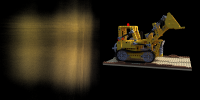

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  2  loss:  0.026614634


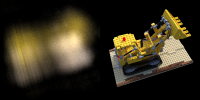

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  3  loss:  0.020298284


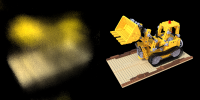

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  4  loss:  0.018317372


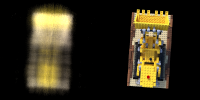

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  5  loss:  0.015946457


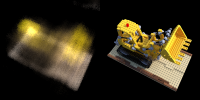

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  6  loss:  0.014869028


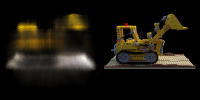

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  7  loss:  0.014235393


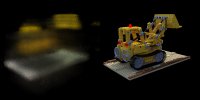

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  8  loss:  0.014457056


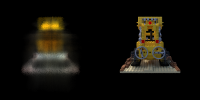

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  9  loss:  0.013696636


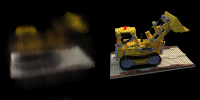

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  10  loss:  0.01330385


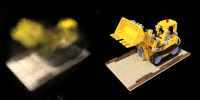

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  11  loss:  0.013630833


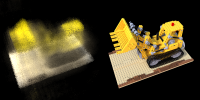

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  12  loss:  0.012605671


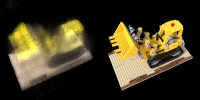

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  13  loss:  0.012677909


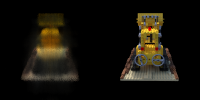

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  14  loss:  0.012479024


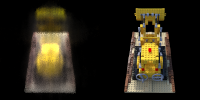

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  15  loss:  0.012687641


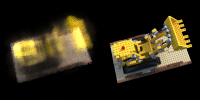

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  16  loss:  0.012069589


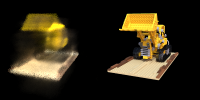

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  17  loss:  0.012360101


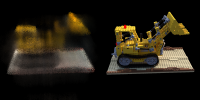

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  18  loss:  0.012088959


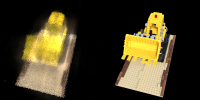

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  19  loss:  0.011884468


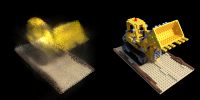

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  20  loss:  0.011817544


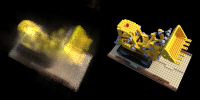

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  21  loss:  0.011829776


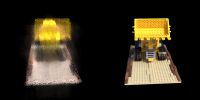

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  22  loss:  0.011702867


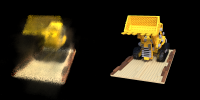

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  23  loss:  0.011626472


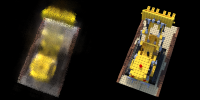

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  24  loss:  0.011401978


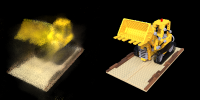

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  25  loss:  0.011143634


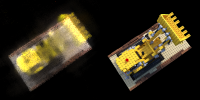

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  26  loss:  0.010860624


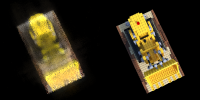

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  27  loss:  0.010809632


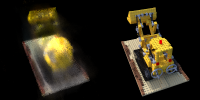

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  28  loss:  0.010799077


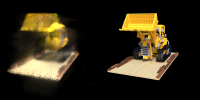

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  29  loss:  0.010639583


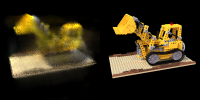

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  30  loss:  0.0107433945


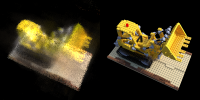

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  31  loss:  0.011064035


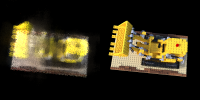

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  32  loss:  0.010521395


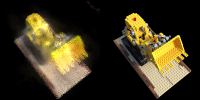

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  33  loss:  0.010415612


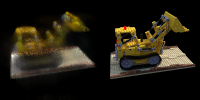

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  34  loss:  0.010425038


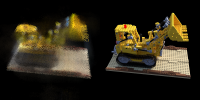

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  35  loss:  0.010319212


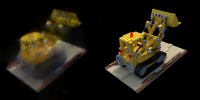

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  36  loss:  0.01033362


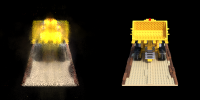

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  37  loss:  0.010491292


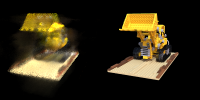

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  38  loss:  0.0102372505


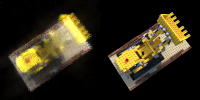

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  39  loss:  0.010130463


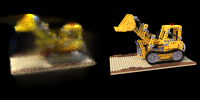

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  40  loss:  0.010214904


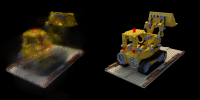

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  41  loss:  0.010461791


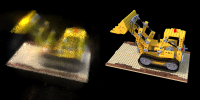

  0%|          | 0/106 [00:00<?, ?it/s]

train epoch:  42  loss:  0.010160171


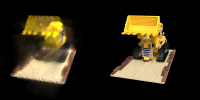

  0%|          | 0/106 [00:00<?, ?it/s]

In [ ]:
class Nerf(nn.Module):
  """ Nerf model according to paper"""
  @nn.compact
  def __call__(self, xyz,dir):
    x = nn.Dense(features=256)(xyz)
    x = nn.relu(x)
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=256)(jnp.concatenate([x,xyz], axis=-1))
    x = nn.relu(x)
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=256)(x)
    sigs = nn.Dense(features=1)(x)
    sigs = nn.relu(sigs)
    x = nn.relu(x)
    x = nn.Dense(features=128)(jnp.concatenate([x,dir], axis=-1))
    x = nn.Dense(features=3)(x)
    col = nn.sigmoid(x)
    return sigs,col
def mse_loss( pred, labels):
  return jnp.mean((pred-labels)**2)
def get_datasets():
  """Load  datasets into memory."""
  data = np.load('tiny_nerf_data.npz')
  images = data["images"]#(106, 100, 100, 3)
  poses = data['poses'] #(106, 4, 4)
  focal = data['focal'] #focal  138.88887889922103
  return images,poses,jnp.repeat(focal,images.shape[0])
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  nerf = Nerf()
  params = nerf.init(rng, jnp.ones([1,60]),jnp.ones([1,24]))['params']
  tx = optax.adam(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=nerf.apply, params=params, tx=tx)
@jax.jit
def train_step(state,batch_imgs,batch_focal,batch_cam_to_world,batch_Tfs,batch_Tns,prngKey):
  """Train for a single step for a batch of images"""
  def loss_fn(params):
    #BatchParams = jnp.repeat(params,batch_imgs.shape[0])
    output_imgs,ground_truths = VolumeRenderingBatch(params,batch_focal,batch_cam_to_world,batch_Tfs,batch_Tns,batch_imgs,prngKey)
    loss = mse_loss(output_imgs,ground_truths)
    return loss,output_imgs
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, output_imgs), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state,loss,output_imgs
def train_epoch(state, train_images,train_poses,train_focals,Tf,Tn, batch_size, epoch, rng):
  """Train for a single epoch."""
  train_ds_size = train_images.shape[0]
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, train_ds_size)
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))
  batch_losses = []
  for perm in tqdm(perms):
    rng,newRng = jax.random.split(rng)
    batch_images = train_images[perm, ...]
    batch_focal = train_focals[perm, ...]
    batch_poses = train_poses[perm, ...]
    batch_Tfs = jnp.repeat(Tf,batch_size) 
    batch_Tns = jnp.repeat(Tn,batch_size)
    #print(batch_images.shape,batch_focal.shape,batch_poses.shape)
    state, loss ,ops= train_step(state, batch_images,batch_focal,batch_poses,batch_Tfs,batch_Tns,newRng)#state, batch_imgs,batch_focal,batch_cam_to_world,prngKey
    batch_losses.append(loss)

  # compute mean of metrics across each batch in epoch.
  batch_losses_np = jax.device_get(batch_losses)

  print("train epoch: ",epoch ," loss: ",np.mean(batch_losses))
  outPutImg = VolumeRenderSingleImage(state.params,batch_focal[0],batch_poses[0],6.0,2.0,batch_images[0].shape,newRng)
  cv2_imshow(cv2.cvtColor(np.hstack([np.asarray(outPutImg)*255,np.asarray(batch_images[0])*255]), cv2.COLOR_BGR2RGB))
  return state

trainImages,trainPoses,trainFocals = get_datasets()
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
learning_rate = 0.001
momentum = 0.9
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.
num_epochs = 100
batch_size = 1 #free colab gpu cant handle more than 1 image at a time

for epoch in range(1, num_epochs + 1):
  # Use a separate PRNG key to permute image data during shuffling
  rng, input_rng = jax.random.split(rng)
  # Run an optimization step over a training batch
  state = train_epoch(state,trainImages,trainPoses,trainFocals,6.0,2.0, batch_size, epoch, input_rng)